In [ ]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [ ]:
# Fetch data for a stock (e.g., Apple Inc. - AAPL) from Yahoo Finance
ticker_symbol = 'RELIANCE.NS'
stock_data = yf.download(ticker_symbol, start='2010-01-01', end='2024-01-28')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Preprocess the data
data = stock_data['Close'].values.reshape(-1, 1)  # Convert to 2D array for scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:

# Create the training and testing datasets
train_data = scaled_data[:int(len(scaled_data) * 0.8)]
test_data = scaled_data[int(len(scaled_data) * 0.8):]

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)



In [ ]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

# Define the model with increased complexity and regularization
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(LSTM(units=32, kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(units=1))


# Compile the model with RMSprop optimizer and adjusted learning rate
model.compile(loss='mse', optimizer=RMSprop(lr=0.0005), metrics=['mean_absolute_error'])


# Add early stopping to prevent overfitting
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100, 128)          66560     
                                                                 
 dropout_9 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm_10 (LSTM)              (None, 100, 64)           49408     
                                                                 
 dropout_10 (Dropout)        (None, 100, 64)           0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:


# Train the model with increased epochs and batch size
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))



Epoch 1/100
42/42 [==============================] - 25s 481ms/step - loss: 0.2157 - mean_absolute_error: 0.0485 - val_loss: 0.1998 - val_mean_absolute_error: 0.1794
Epoch 2/100
42/42 [==============================] - 17s 404ms/step - loss: 0.1380 - mean_absolute_error: 0.0334 - val_loss: 0.1099 - val_mean_absolute_error: 0.0481
Epoch 3/100
42/42 [==============================] - 17s 405ms/step - loss: 0.0887 - mean_absolute_error: 0.0323 - val_loss: 0.0689 - val_mean_absolute_error: 0.0343
Epoch 4/100
42/42 [==============================] - 18s 436ms/step - loss: 0.0570 - mean_absolute_error: 0.0326 - val_loss: 0.1137 - val_mean_absolute_error: 0.2645
Epoch 5/100
42/42 [==============================] - 17s 408ms/step - loss: 0.0364 - mean_absolute_error: 0.0300 - val_loss: 0.0627 - val_mean_absolute_error: 0.1859
Epoch 6/100
42/42 [==============================] - 17s 404ms/step - loss: 0.0238 - mean_absolute_error: 0.0289 - val_loss: 0.0224 - val_mean_absolute_error: 0.0621
Epoc

In [ ]:

# Save the model
model.save('stock_prediction_model_9.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 1s 73ms/step - loss: 0.0058 - mean_absolute_error: 0.0617
Test Loss: 0.005846407264471054, Test MAE: 0.06169433519244194


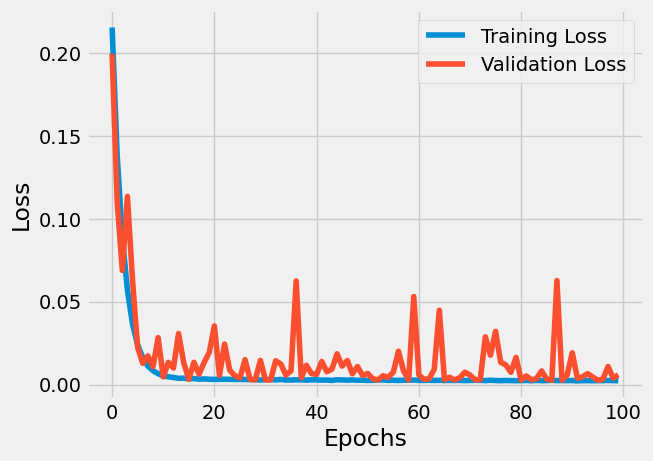

In [ ]:

# Evaluate the model with additional metrics
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

19/19 [==============================] - 1s 70ms/step


In [ ]:
# Ensure both y_train and train_predict have compatible shapes
print(f"y_train shape: {y_train.shape}")
print(f"train_predict shape: {train_predict.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"test_predict shape: {test_predict.shape}")

y_train shape: (2677,)
train_predict shape: (2677, 1)
y_test shape: (594,)
test_predict shape: (594, 1)


In [ ]:
# Inverse transform the predictions to get actual stock prices
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [ ]:
# Model evaluation
from sklearn.metrics import mean_squared_error
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 99.52320261717898
Test RMSE: 180.70703944840392


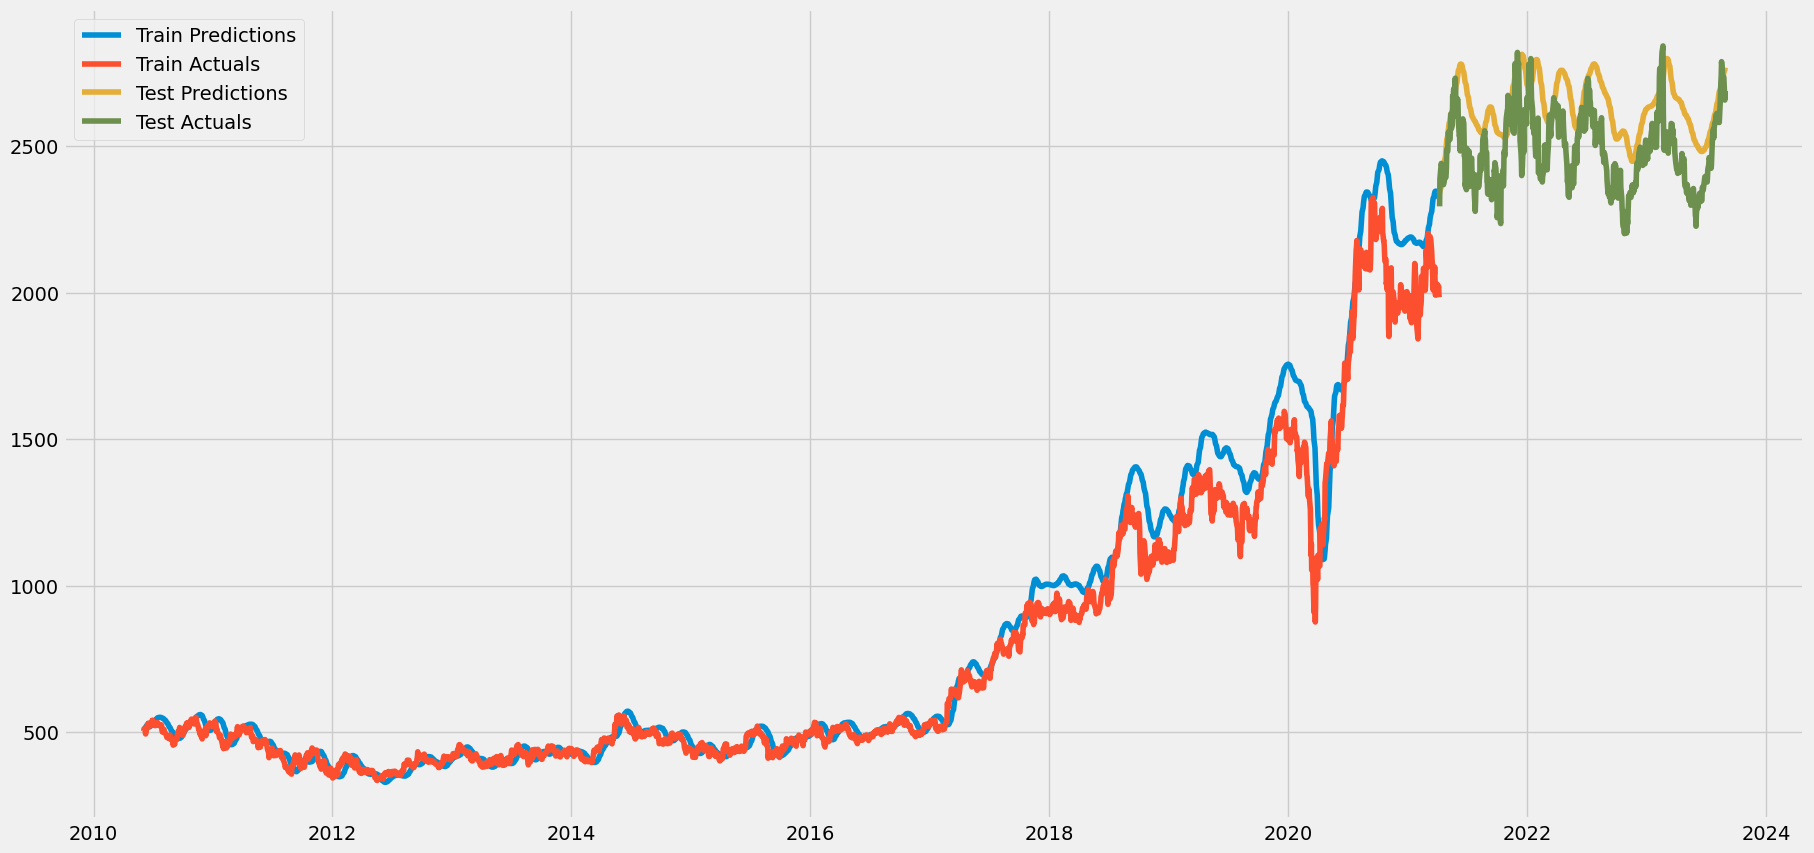

In [ ]:
# Visualize the results
plt.style.use('fivethirtyeight')
# Plot the data
plt.figure(figsize=(20, 10))

# Plot training predictions and actuals
plt.plot(stock_data.index[time_step+1:time_step+len(train_predict)+1], train_predict, label='Train Predictions')
plt.plot(stock_data.index[time_step+1:time_step+len(train_predict)+1], y_train[0], label='Train Actuals')

# Plot testing predictions and actuals
test_index = stock_data.index[time_step+len(train_predict)+1:time_step+len(train_predict)+1+len(test_predict)]
plt.plot(test_index, test_predict, label='Test Predictions')
plt.plot(test_index[:len(test_predict)], y_test[0][:len(test_predict)], label='Test Actuals')

plt.legend()
plt.show()


In [ ]:
# Extend predictions for the next 10 days
future_time_steps = 10
future_predictions = []

In [ ]:
# Use the last sequence from the testing data to start predicting the future
last_sequence = X_test[-1]

for i in range(future_time_steps):
    # Predict the next price
    next_prediction = model.predict(np.array([last_sequence]))[0, 0]

    # Append the prediction to the list of future predictions
    future_predictions.append(next_prediction)

    # Update the last sequence with the new prediction
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_prediction

1/1 [==============================] - 0s 50ms/step


In [ ]:

# Inverse transform the future predictions to get the actual stock prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [ ]:

# Get the last date in the original dataset
last_date = stock_data.index[-1]

# Generate dates for the next 10 days
next_dates = pd.date_range(start=last_date, periods=future_time_steps + 1)[1:]  # Skip the last date

In [ ]:
 #Print the predicted prices for the next 10 days along with dates
print("Predicted prices for the next 10 days:")
for date, prediction in zip(next_dates, future_predictions):
    print(f"{date.strftime('%Y-%m-%d')}: {prediction[0]:.2f}")

Predicted prices for the next 10 days:
2024-01-26: 2768.04
2024-01-27: 2776.13
2024-01-28: 2784.13
2024-01-29: 2792.00
2024-01-30: 2799.72
2024-01-31: 2807.27
2024-02-01: 2814.66
2024-02-02: 2821.87
2024-02-03: 2828.92
2024-02-04: 2835.79


1/1 [==============================] - 0s 49ms/step


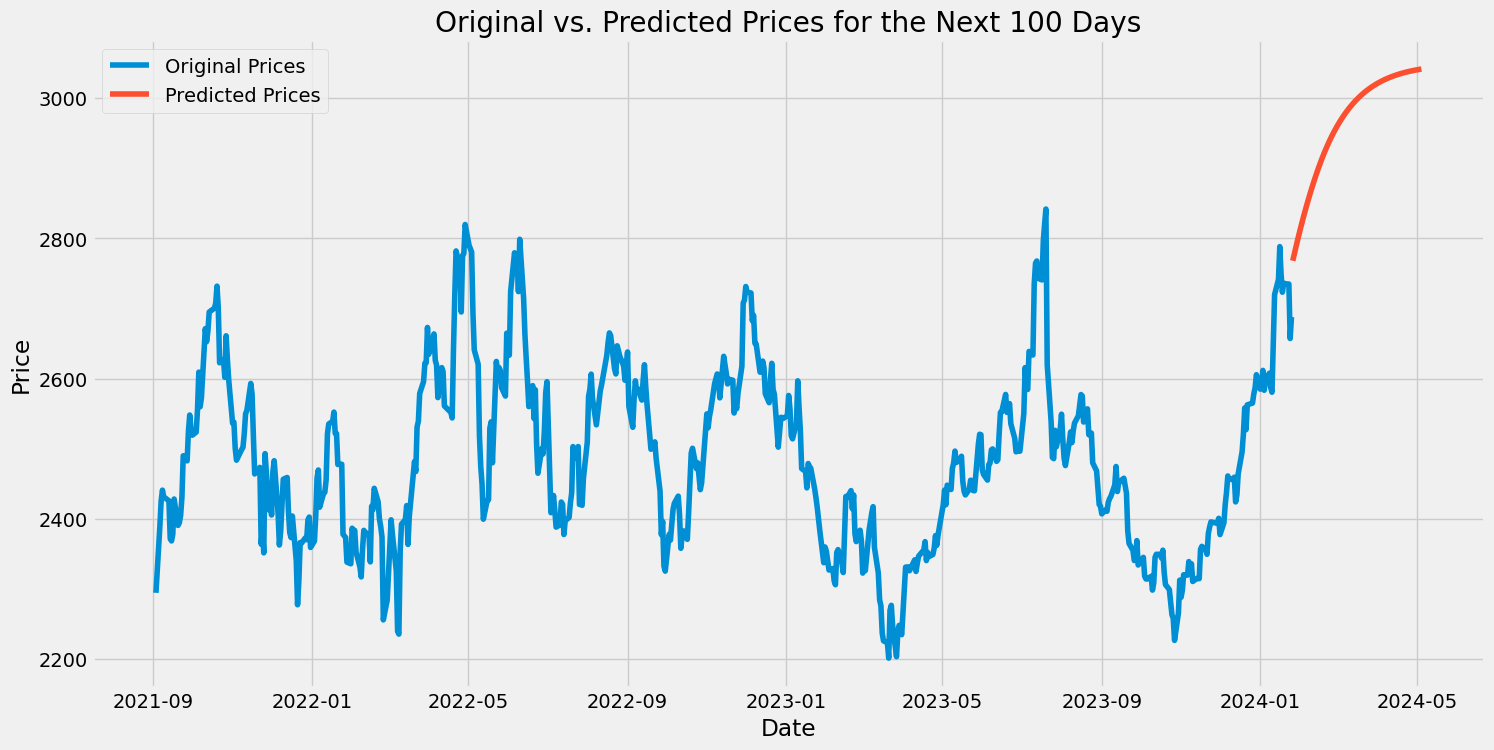

In [ ]:
# Extend predictions for the next 100 days
future_time_steps = 100
future_predictions = []

# Use the last sequence from the testing data to start predicting the future
last_sequence = X_test[-1]

for i in range(future_time_steps):
    # Predict the next price
    next_prediction = model.predict(np.array([last_sequence]))[0, 0]

    # Append the prediction to the list of future predictions
    future_predictions.append(next_prediction)

    # Update the last sequence with the new prediction
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_prediction

# Inverse transform the future predictions to get the actual stock prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate dates for the next 100 days
next_dates = pd.date_range(start=last_date, periods=future_time_steps + 1)[1:]  # Skip the last date

# Plot the original and predicted prices for the next 100 days
plt.figure(figsize=(16, 8))
plt.plot(stock_data.index[-len(y_test[0]):], y_test[0], label='Original Prices')
plt.plot(next_dates, future_predictions, label='Predicted Prices')
plt.title('Original vs. Predicted Prices for the Next 100 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()